# PRACTICA 2 ML 
BEATRIZ SICILIA GÓMEZ 
INÉS SAAVEDRA VILLAFRUELA 

**Objetivo**: 
1. Analizar el conjunto de datos. 
2. Crear un sistema de recomendación de artistas para usuarios.
   
**Entregar**: Este cuaderno de jupyter con el trabajo hecho y comentado.

**Datos**: 

Los datos suministrados ya han sido procesados, limpiados y estructurados para simplificar su manejo y análisis. 

Para aquellos interesados en explorar y manipular el conjunto de datos original, así como entender la estructura, podéis descargarlo directamente aquí: 

https://grouplens.org/datasets/hetrec-2011/.

In [ ]:
### ARCHIVOS DE DATOS DISPONIBLES: 
#1. artists.dat: info de los artistas que escuchan y etiquetan (tag) los users
#2. tags.dat: info de los tags que se pueden asignar a los artistas
#3. user_artists.dat: info de los artistas que escuchan los usuarios
#4. user_friends.dat: info de los amigos de los usuarios
#5. user_taggedartists.dat: tags que los usuarios asignan a los artistas
#6. user_taggedartists-timestamps.dat: igual que el anterior pero con timestamps

### LECTURA Y EDA

In [1]:
#Librerias 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
artists = pd.read_csv('./hetrec2011-lastfm-2k/artists-v2.dat', header=0, sep='\t')
user_tag_artist = pd.read_csv('./hetrec2011-lastfm-2k/user_taggedartists.dat', header=0, sep='\t')
tags = pd.read_csv('hetrec2011-lastfm-2k/tags.dat', header=0, sep='\t', encoding='latin-1')
users = pd.read_csv('hetrec2011-lastfm-2k/user_artists.dat',header=0, sep='\t')


Análisis general de todas las tablas

In [33]:
#Info artistas
artists.head()

,artistID,name,freq,listeners
0,89,Lady Gaga,611,3798959
1,289,Britney Spears,522,3243214
2,288,Rihanna,484,4542147
3,227,The Beatles,480,3658694
4,300,Katy Perry,473,3721531


In [34]:
#artistas escuchados por cada usuario. 
users.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [37]:
#numero de artisID distintos en users 
len(users['artistID'].unique())

17632

In [5]:
#Tag que el usuario asigna a un artista, y en el momento en el que se lo asignó.
user_tag_artist.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [6]:
#POSIBLES TAGS QUE SE PUEDEN ASIGNAR:
print("\nInformación de etiquetas:")
print(tags.head())



Información de etiquetas:
   tagID           tagValue
0      1              metal
1      2  alternative metal
2      3          goth rock
3      4        black metal
4      5        death metal


In [8]:
#MIRAMOS NAs 

#No hay nulos en el fichero de artistas
artists.isna().sum()

#No hay nulos en el fichero de usuarios.
users.isna().sum()

userID      0
artistID    0
weight      0
dtype: int64

In [9]:
#Artistas con más listeners.
artists.sort_values(by='listeners', ascending=False).head(10)

,artistID,name,freq,listeners
12,65,Coldplay,369,5369132
11,154,Radiohead,393,4718748
38,220,Red Hot Chili Peppers,222,4608144
2,288,Rihanna,484,4542147
43,475,Eminem,204,4504111
16,229,The Killers,304,4416820
81,331,Kanye West,134,4375723
24,234,Nirvana,258,4257983
8,190,Muse,400,4080161
42,959,Queen,208,4002970


Sobre los tags

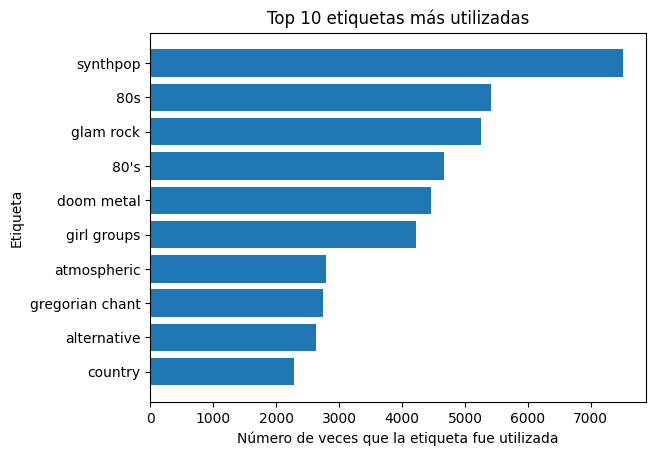

In [10]:
#Aunque en este ejercicio no se vaya a utilizar, es interesante conocer las etiquetas que más se usan para futuras aplicaciones de este sistema de recomendacion

tag_counts = user_tag_artist['tagID'].value_counts().sort_values(ascending=False)[:10]
top_tags = tags.loc[tag_counts.index]['tagValue']

plt.barh(top_tags, tag_counts)
plt.xlabel('Número de veces que la etiqueta fue utilizada')
plt.ylabel('Etiqueta')
plt.title('Top 10 etiquetas más utilizadas')
plt.gca().invert_yaxis()
plt.show()

Sobre la variable weight, que utilizaremos como rating

{'whiskers': [<matplotlib.lines.Line2D at 0x222be74a140>,
 'caps': [<matplotlib.lines.Line2D at 0x222be74a680>,
 'boxes': [<matplotlib.lines.Line2D at 0x222be749ea0>],
 'medians': [<matplotlib.lines.Line2D at 0x222be74abc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x222be74ae60>],
 'means': []}

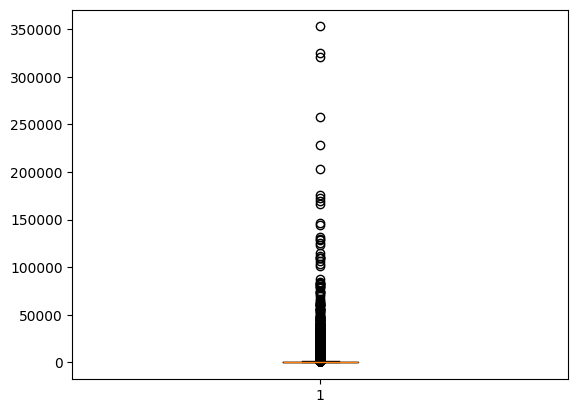

In [12]:
#Boxplot de la variable weight 
plt.boxplot(users['weight'])

Buscando outliers de la variable weight 

In [13]:
from matplotlib.cbook import boxplot_stats

def explore_outliers(df, num_vars):
    outliers_df = dict()
    for k in range(len(num_vars)):
        var = num_vars[k]
        sns.boxplot(df, x=var)
        outliers_df[var] = boxplot_stats(df[var])[0]["fliers"]
        out_pos = np.where(df[var].isin(outliers_df[var]))[0].tolist() 
        out_idx = [df[var].index.tolist()[ k ] for k in out_pos]
        outliers_df[var] = {"values": outliers_df[var], 
                            "positions": out_pos, 
                            "indices": out_idx}
    return outliers_df

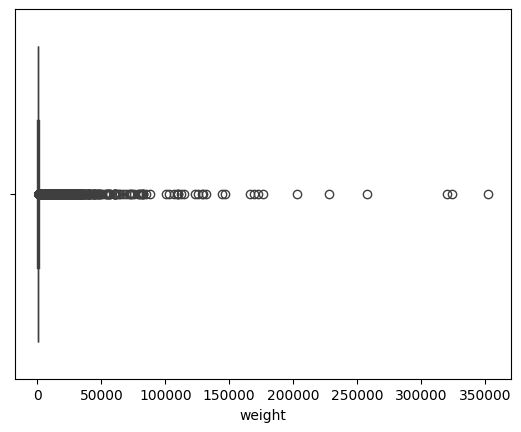

In [14]:
out_XTR = explore_outliers(users, ['weight'])

In [23]:
print('Percetage of outliers', len(out_XTR.get('weight').get('indices'))/len(users))

Percetage of outliers 0.1012990930047181


Comentario:Se decidió no eliminar los outliers ya que representaban un porcentaje muy pequeño del total. Queremos mantener los weights que son "outliers" para capturar el comportamiento de aquellos que se desvian de la tendencia principal 

### CONSTRUCCIÓN DE LA MATRIZ DE RATINGS

In [4]:
ratings_matrix = users.pivot_table(values='weight', index='userID', columns='artistID')
ratings_matrix.head()

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sparsity del conjunto de datos

In [32]:
#Calcularemos la sparsity de la matriz de ratings 
#El sparsity o la dispersión es la proporción de valores desconocidos respecto a todos los valores posibles. 
#Los sistemas de recomendación se caracterizan por tener valores muy altos de sparsity, puesto que no tendremos todas las valoraciones de todos los usuarios para todos los items. 

def print_sparsity(df):
  n_users = df.userID.nunique()
  n_items = df.artistID.nunique()
  n_ratings = len(df)
  rating_matrix_size = n_users * n_items
  sparsity = 1 - n_ratings / rating_matrix_size

  print(f"Number of users: {n_users}")
  print(f"Number of items: {n_items}")
  print(f"Number of available ratings: {n_ratings}")
  print(f"Number of all possible ratings: {rating_matrix_size}")
  print("-" * 40)
  print(f"SPARSITY: {sparsity * 100.0:.2f}%")


In [33]:
print_sparsity(users)

Number of users: 1892
Number of items: 17632
Number of available ratings: 92834
Number of all possible ratings: 33359744
----------------------------------------
SPARSITY: 99.72%


### PLANTEAMIENTO DEL PROBLEMA 
- Problema: Lo que queremos es proporcionar recomendaciones de artistas nuevos a un usuario. 
- Es un problema explícito, donde tenemos una columna weights que representa el número de escuchas de un usuario a un artista.

---------------------

#### MEMORY-BASED COLLABORATIVE FILTERING

#### User-based collaborative filtering: 
- Solución: Buscar usuarios que sean similares al usuario target para poder hacer las recomendaciones. 

- Vamos a utilizar la matriz de usuarios-artistas (Sería la matriz de ratings): 
    - Dimensiones: (mxn), m usuarios, n artistas.
    - Cada fila de la matriz es un usuario y cada columna es un artista.
    - Cada celda es el número de veces/minutos que el usuario escuchó al artista (weight)

- Cómo calcular la similitud entre usuarios? 
    - Utilizando similitud del coseno 
    - Utilizando fórmula de Pearson

- Cuando tengamos los k usuarios más similares a nuestro usuario target u (Basado en similitud)
    - Para los artistas que u no ha escuchado crearemos un rating basado en lo que los k usuarios calificaron ponderado por su peso (similitud)
    - Ordenamos por rating descendente y hacemos top-n recomendaciones. 

#### Item-based collaborative filtering: 

FALTA EXPLICAR 

--------------------

#### MODEL-BASED COLLABORATIVE FILTERING 


FALTA EXPLICAR


----------------

### A) MEMORY BASED 

1. USER-BASED

In [36]:
users.columns

Index(['userID', 'artistID', 'weight'], dtype='object')

In [34]:
def userknn_cornac(df:pd.DataFrame):
  import cornac
  from cornac.utils import cache
  from cornac.eval_methods import RatioSplit
  from cornac.models import UserKNN

  df = df.astype({'userID':object, 'artistID':object})
  records = df.to_records(index=False)
  result = list(records)

  K = 3  # number of nearest neighbors
  VERBOSE = False
  SEED = 42
  uknn_cosine = UserKNN(k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE)
  uknn_cosine_mc = UserKNN(k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE)
  uknn_pearson = UserKNN(k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE)
  uknn_pearson_mc = UserKNN(k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE)
  
  # Metrics
  rec_300 = cornac.metrics.Recall(k=300)
  rec_900 = cornac.metrics.Recall(k=900)
  prec_30 = cornac.metrics.Precision(k=30)
  rmse = cornac.metrics.RMSE()
  mae = cornac.metrics.MAE()
  
  ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
  cornac.Experiment(eval_method=ratio_split,
                    models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
                    metrics=[rec_300, rec_900, prec_30, rmse, mae],
                    ).run()
  
  userknn_models = {'uknn_cosine': uknn_cosine, 'uknn_cosine_mc': uknn_cosine_mc,
                'uknn_pearson': uknn_pearson, 'uknn_pearson_mc': uknn_pearson_mc}
  
  return userknn_models

In [35]:
userknn_models = userknn_cornac(users)


TEST:
...
                   |      MAE |      RMSE | Precision@30 | Recall@300 | Recall@900 | Train (s) | Test (s)
------------------ + -------- + --------- + ------------ + ---------- + ---------- + --------- + --------
UserKNN-Cosine     | 985.6059 | 1434.1668 |       0.0017 |     0.0733 |     0.1591 |    0.3061 |  53.5044
UserKNN-Cosine-MC  | 980.6502 | 1454.0607 |       0.0014 |     0.0409 |     0.1009 |    0.3630 |  53.5125
UserKNN-Pearson    | 980.6502 | 1454.0607 |       0.0014 |     0.0409 |     0.1009 |    0.3547 |  34.4227
UserKNN-Pearson-MC | 980.6502 | 1454.0607 |       0.0014 |     0.0409 |     0.1009 |    0.2865 |  27.6946



In [36]:
df_user_10k = users.set_index("userID")
df_item_10k = users.set_index("artistID")

In [37]:
model = userknn_models.get('uknn_pearson_mc')

In [39]:
#Mapping id y indice en la matriz de ratings. 
model.train_set.uid_map.items()

odict_items([(1761, 0), (915, 1), (644, 2), (1736, 3), (1042, 4), (1574, 5), (714, 6), (1939, 7), (773, 8), (268, 9), (629, 10), (113, 11), (1925, 12), (115, 13), (793, 14), (1015, 15), (1164, 16), (1506, 17), (842, 18), (98, 19), (1831, 20), (59, 21), (274, 22), (452, 23), (1732, 24), (1120, 25), (1209, 26), (1063, 27), (21, 28), (1329, 29), (1034, 30), (1375, 31), (129, 32), (456, 33), (1672, 34), (187, 35), (999, 36), (1819, 37), (1213, 38), (953, 39), (2025, 40), (326, 41), (1811, 42), (1176, 43), (338, 44), (910, 45), (1082, 46), (366, 47), (1964, 48), (1331, 49), (194, 50), (601, 51), (442, 52), (2010, 53), (1377, 54), (950, 55), (1558, 56), (1745, 57), (1619, 58), (1587, 59), (1815, 60), (293, 61), (1969, 62), (1191, 63), (1862, 64), (1223, 65), (27, 66), (1423, 67), (2068, 68), (1287, 69), (546, 70), (295, 71), (764, 72), (1626, 73), (1149, 74), (2066, 75), (1495, 76), (837, 77), (1376, 78), (1206, 79), (619, 80), (1572, 81), (712, 82), (1709, 83), (871, 84), (2004, 85), (525, 

In [40]:
import pandas as pd

def uknn_get_scores(UID, model, user_df, artists_df, TOPK=5):
    # Cojo el índice del usuario en la matriz de ratings, UIDX: 
    UIDX = list(model.train_set.uid_map.items())[UID][0]

    # Obtengo las recomendaciones y los scores
    # Rank method devuelve una lista con los índices de los elementos recomendados y otra con los scores de las recomendaciones.
    recommendations, scores = model.rank(UID)
    
    # Obtener los IDs de los productos recomendados
    recommended_ids = [model.train_set.iid_map[i] for i in recommendations[:TOPK]]
    
    # Crear un DataFrame con los IDs de los productos recomendados y sus scores
    recommendations_df = pd.DataFrame({'ProductID': recommended_ids, 'Score': scores[recommendations[:TOPK]]})
    
    # Fusionar la tabla de recomendaciones con la tabla de artistas
    recommendations_df = pd.merge(recommendations_df, artists_df, left_on='ProductID', right_on='artistID', how='left')
    recommendations_df.drop(columns=['artistID'], inplace=True)  # Eliminar la columna artistID redundante
    
    print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UID}:")
    
    return recommendations_df


In [41]:
uknn_get_scores(32, model, df_user_10k, artists)


TOP 5 RECOMMENDATIONS FOR USER 32:


,ProductID,Score,name,freq,listeners
0,1718,84237.620465,Ani DiFranco,10,510333
1,2830,41395.283184,Kap Bambino,6,87207
2,808,32403.932812,Rise Against,81,2025012
3,1008,17292.259450,Level 42,6,334025
4,13743,14786.035825,PeeWee,3,7629


2. ITEM-BASED

In [1]:
def itemknn_cornac(df):
  import cornac
  from cornac.models import ItemKNN
  from cornac.eval_methods import RatioSplit
  df = df.astype({'userID':object, 'artistID':object})
  records = df.to_records(index=False)
  result = list(records)
  K = 50  # number of nearest neighbors
  VERBOSE = False
  SEED = 42
  iknn_cosine = ItemKNN(k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE)
  iknn_pearson = ItemKNN(k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE)
  iknn_pearson_mc = ItemKNN(k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE)
  iknn_adjusted = ItemKNN(k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE)

  # Metrics
  rmse = cornac.metrics.RMSE()
  mae = cornac.metrics.MAE()

  ratio_split = RatioSplit(result, test_size=0.1, seed=SEED, verbose=VERBOSE)
  cornac.Experiment(eval_method=ratio_split,
                    models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
                    metrics=[rmse, mae],
                    ).run()
  itemknn_models = {'iknn_cosine': iknn_cosine, 'iknn_pearson': iknn_pearson,
                'iknn_pearson_mc': iknn_pearson_mc, 'iknn_adjusted': iknn_adjusted}
  return itemknn_models


In [4]:
itemknn_models = itemknn_cornac(users)


TEST:
...
                       |      MAE |      RMSE | Train (s) | Test (s)
---------------------- + -------- + --------- + --------- + --------
ItemKNN-Cosine         | 799.5497 | 1082.4923 |   24.1446 |   2.8571
ItemKNN-Pearson        | 763.8722 | 1042.9618 |    7.0127 |   3.1313
ItemKNN-Pearson-MC     | 740.7850 | 1033.7617 |    7.2770 |   2.6506
ItemKNN-AdjustedCosine | 739.3351 | 1034.7199 |    5.4272 |   2.6515



In [5]:
model = itemknn_models.get('iknn_adjusted')

In [6]:
artists.head(3)

,artistID,name,freq,listeners
0,89,Lady Gaga,611,3798959
1,289,Britney Spears,522,3243214
2,288,Rihanna,484,4542147


In [9]:
#Get name of an artist given its ID 
def get_artist_name(artistID):
    artist = artists[artists['artistID'] == artistID]
    if not artist.empty:
        return artist.iloc[0]['name']
    else:
        return "Artist not found" 


In [17]:
def item_profiling(UID, model, item_df, TOPK=5):

  #Ratings matrix, each row is a user and each column is an item
  rating_mat = model.train_set.matrix

  #Get the index of the item in the ratings matrix
  UIDX = list(model.train_set.iid_map.items())[UID][0]

  #product id
  print(f"artistID = {UIDX}")

  #Print artist name, getting data from artists

  name = get_artist_name(UIDX)
  print(name)

  print("-" * 35)

  #item data, product id, user_id, rating
  print(item_df.loc[UIDX])

  #Transform to pd dataframe
  ratings = pd.DataFrame(rating_mat.toarray())

  #Get the ratings of the item, it contains the ratings of all users for the item
  item_ratings = ratings.iloc[UID]

  #Get the indices of the TOPK users that rated the item the best
  top_rated_users = np.argsort(item_ratings)[-TOPK:]
  print(f"\nTOP {TOPK} RECOMMENDED USERS FOR ARTIST {name}:")
  print("-" * 35)

  #Print the data of the TOPK users
  print(df_item_10k.iloc[top_rated_users.array])

In [18]:
top_rated_items = item_profiling(10, model, df_item_10k)

artistID = 166
The Cranberries
-----------------------------------
          userID  weight
artistID                
166            4     445
166           49      87
166          103      23
166          125     126
166          135     561
...          ...     ...
166         1998     321
166         2001     486
166         2045      41
166         2096     391
166         2097     119

[70 rows x 2 columns]

TOP 5 RECOMMENDED USERS FOR ARTIST The Cranberries:
-----------------------------------
          userID  weight
artistID                
1122          33     689
448           10     178
256            6      19
119            3     142
157            4     732


### B) MODEL BASED

In [26]:
artists

,artistID,name,freq,listeners
0,89,Lady Gaga,611,3798959
1,289,Britney Spears,522,3243214
2,288,Rihanna,484,4542147
3,227,The Beatles,480,3658694
4,300,Katy Perry,473,3721531
...,...,...,...,...
4557,7007,De-Phazz,3,612135
4558,7472,Odd Nosdam,3,95162
4559,8309,Jerry Lee Lewis,3,611406
4560,10549,Lil B,3,217104


In [30]:
len(users['artistID'].unique())

17632

In [31]:
len(artists['artistID'].unique())

4562

In [27]:
ratings_matrix

artistID,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
userID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
ratings_matrix
#shape 
ratings_matrix.shape


(1892, 17632)

In [5]:
#For this one, we want to keep only the artist that have been listened by at least 50 users, filter user df
users_filtered = users[users['artistID'].isin(ratings_matrix.columns[ratings_matrix.count() > 50])]

In [8]:
users_filtered['artistID'].nunique()

316

In [14]:
users_filtered

,userID,artistID,weight
0,2,51,13883
2,2,53,11351
4,2,55,8983
5,2,56,6152
7,2,58,4616
...,...,...,...
92717,2097,1376,123
92719,2097,1412,535
92736,2099,748,72
92790,2100,841,553


In [16]:
#A partir de este, creamos la matriz de ratings R_df. Tendrá NaNs en los artistas que no han sido escuchados por un usuario
#Habrá muchos NaNs ya que en sistemas de recomendación tratamos con matrices muy dispersas.
R_df = users_filtered.pivot(index = 'userID', columns ='artistID', values = 'weight')
R_df.head()

artistID,7,51,53,55,56,58,59,64,65,67,...,2094,2277,2343,2346,2347,2521,2523,2531,3057,3200
userID,,,,,,,,,,,,,,,,,,,,,
2,NaN,13883.0,11351.0,8983.0,6152.0,4616.0,4337.0,3644.0,3579.0,3301.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,228.0,686.0,NaN,NaN,NaN,NaN,420.0,301.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,181.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,3151.0,NaN,NaN,NaN,NaN,NaN,2540.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
#Los NaNs los rellenamos con 0s
R_df = R_df.fillna(0)
R_df.head()

artistID,7,51,53,55,56,58,59,64,65,67,...,2094,2277,2343,2346,2347,2521,2523,2531,3057,3200
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,13883.0,11351.0,8983.0,6152.0,4616.0,4337.0,3644.0,3579.0,3301.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,228.0,686.0,0.0,0.0,0.0,0.0,420.0,301.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,181.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,3151.0,0.0,0.0,0.0,0.0,0.0,2540.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
#Centraremos la matriz de ratings utilizando la media de cada usuario. 
R = R_df.to_numpy()

user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

print(R.shape)
print(np.count_nonzero(R))

(1844, 316)
38407


In [23]:
from scipy.sparse.linalg import svds
import math
from numpy.linalg import matrix_rank

In [27]:
#Como tenemos 124 columnas, vamos a iterar para distintos valores de k y ver cómo se comporta el error.
latents = [3, 10, 20, 30, 40, 50, 100, 120, 200, 220, 300, 315]
rmse_errors = [] 
for latent_dim in latents:
    U, sigma, Vt = svds(R_demeaned, k=latent_dim)
    #Matriz sigma: es una matriz diagonal de valores singulares
    sigma = np.diag(sigma)
    Rpred = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    MSE = np.square(np.subtract(R, Rpred)).mean() 
    RMSE = math.sqrt(MSE)
    rmse_errors.append(RMSE)

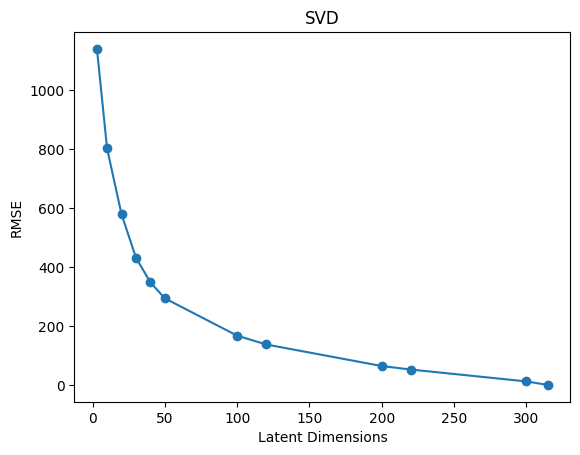

In [28]:
import seaborn as sns
plt.xlabel('Latent Dimensions')
plt.ylabel('RMSE')
plt.title('SVD')
plt.plot(latents, rmse_errors, 'o-')
plt.show()

In [29]:
#En este caso escogemos 200 dimensiones latentes, ya que ahí parece que se estabiliza el error 
latent_dim = 200

U, sigma, Vt = svds(R_demeaned, k=latent_dim)

sigma = np.diag(sigma)

#Predicciones: le sumamos la media del usuario. 
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

#Creamos un dataframe con las predicciones
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head()

artistID,7,51,53,55,56,58,59,64,65,67,...,2094,2277,2343,2346,2347,2521,2523,2531,3057,3200
0,-45.631195,13880.330390,10770.994159,8981.265921,6148.356506,4798.741381,4609.200035,3793.285511,3608.820026,3295.943191,...,3.679089,36.446232,7.523315,82.420234,-26.739738,64.399463,26.603435,92.684638,152.568587,-182.087309
1,-53.060102,235.081495,482.699229,-4.406698,-0.048819,209.222856,79.499114,401.201090,321.920095,-0.848272,...,3.051492,7.011676,-56.808463,15.338729,21.974061,-16.000886,1.022952,32.125856,55.193709,-9.894609
2,8.349206,1.381888,114.149866,0.307087,-0.191304,3.411280,44.759687,-8.405973,3.406942,-0.847092,...,6.423593,32.016970,-27.609952,-1.220191,-7.892131,4.189651,-4.552748,-41.708613,-10.876975,6.443951
3,0.133468,-0.003590,0.119841,0.185810,0.027225,0.163269,0.604328,-0.607845,0.021579,-0.035671,...,0.707169,-0.169117,0.010330,-0.103183,0.264222,0.891567,1.065406,0.024986,0.239892,-0.056774
4,-85.248433,0.233906,-52.715554,3148.643959,0.341261,-8.660349,49.098383,39.689400,-12.105567,2533.621969,...,-99.820108,9.587319,-1.231043,58.483795,18.522468,-103.497534,-220.655481,33.580091,1.805038,-10.706385


In [ ]:
#FALTA SOLO FUNCIÓN PARA HACER RECOMENDACIONES. 
